In [153]:
import numpy as np
import math
import matplotlib.pyplot as plt
from node import Node
from node2 import Node2
import pandas as pd
import numpy.linalg as la
import pickle
import random

In [154]:
#Circles test case

# observed = np.array([1.0, 1.0, 1.0, 1.0, 1.0,
#                      1.0, 2.0, 2.0, 2.0, 1.0, 
#                      1.0, 2.0, 2.0, 2.0, 1.0, 
#                      1.0, 2.0, 2.0, 2.0, 1.0, 
#                      1.0, 1.0, 1.0, 1.0, 2.0])

# expected = np.ones(25)

In [155]:
#Original test case (3 random elements):

# expected = np.random.normal(100, 20, 3)
# poissons = np.vectorize(lambda x: np.random.poisson(x))
# observed = poissons(expected)


# expected = np.array([86.5, 113.55, 101.32])
# observed = np.array([265, 345, 324])
# observed = np.array([50, 345, 324])

In [156]:
# 5-element test case:

# expected = np.random.normal(100, 50, 6)
# observed = poissons(expected)
# observed = np.array([100, 170,  100,  100,  200])

expected = np.ones(5)*100
observed = np.ones(5)*50

theta = pd.DataFrame([[0, 1, 1, 0, 0],
                      [1, 0, 1, 0, 1],
                      [0, 0, 0, 1, 1],
                      [1, 1, 1, 0, 0],
                      [0, 0, 1, 0, 0]])

In [157]:
# path = r"C:\Users\joles\OneDrive\Documents\ML4G\train.csv"
# path2 = r"C:\Users\joles\OneDrive\Documents\ML4G\mnist_bin.csv"

# theta = pd.read_csv(path)
# labels = theta['label']
# # theta = theta.drop(['label'], axis=1)
# theta = pd.read_csv(path2)
# theta = theta.drop(['Unnamed: 0'], axis=1)
# # theta.head()

# # test_set = [random.randint(0, 42000) for i in range(100)]

# rand = 41999 #.random.randint(0, 42000)
# subset = theta.iloc[rand]
# # lbl = subset[0]
# # theta = theta.drop(test_set,axis=0)

In [158]:
# with open('test_set.pkl', 'wb') as f:
#         pickle.dump(test_set, f)

# with open('test_set.pkl', 'rb') as f: 
#     test_set = pickle.load(f)


# # with open('theta.pkl', 'wb') as f:
# #         pickle.dump(theta, f)

# with open('theta.pkl', 'rb') as f: 
#     theta = pickle.load(f)

# subset = theta.iloc[41999]

In [159]:
#Build Tree from MNIST

# tree = Node(theta= theta, name= '*')
# tree.build_tree(theta=theta, min_filters_to_split=10000)

# better_tree = Node(theta=theta, name= 'btree_')
# better_tree.build_tree(theta=theta, min_filters_to_split=100)

# no_tree = Node(theta=theta, name='***')
# no_tree.build_tree(theta=theta, max_depth=0)

# tree2 = Node2(theta=theta, name='*-*')
# tree2.build_tree(theta=theta, min_filters_to_split=10000)
#______________________________________________________________

#Save/Load Tree from Pickle File:

# with open('mnist_tree.pkl', 'wb') as f:
#         pickle.dump(tree, f)

# with open('mnist_tree.pkl', 'rb') as f: 
#     tree = pickle.load(f)

# with open('btree_.pkl', 'wb') as f:
#         pickle.dump(better_tree, f)

# with open('btree_.pkl', 'rb') as f: 
#     better_tree = pickle.load(f)

In [160]:
#tree takes around 10-12 min to build
# tree.left.left.left.theta
# tree.left.left.right.theta
# tree.left.right.left.theta
# tree.left.right.right.theta
# tree.right.left.theta
# tree.right.right.theta

# TREE SHAPE: 

#                         ROOT
#                      /        \
#                      L         R     L1
#                   /    \      / \
#                  L      R    L   R   L2
#                 / \    / \
#                L   R  L   R          L3

In [161]:
def llri(obs, exp, q): #score function for poisson (one element)
    return obs*np.log(q) + exp*(1-q)

def llri_pen(obs, exp, q, delta): #penalized score function for poisson (one element)
    return obs*np.log(q) + exp*(1-q) - delta

llr = np.vectorize(llri) #generate unpenalized scores for a given q value

llr_pen = np.vectorize(llri_pen) #genereate penalized scores for a given q value

In [162]:
#DEFINED FUNCTIONS FOR USE IN ALGORITHM:

#BINARY SEARCH FUNCTIONS: ################################################
def q_min(obs, exp):

    minimum = 0.000001
    qmle = 1

    while abs(qmle - minimum) > 0.00000001:
        q_mid = (minimum + qmle)/2

        if llri(obs, exp, q_mid) > 0:
            qmle = qmle - (qmle - minimum)/2
        else:
            minimum = minimum + (qmle - minimum)/2
    return (minimum + qmle)/2

def q_max(obs, exp):

    maximum = 10000000
    qmle = 1

    while abs(maximum - qmle) > 0.000001:
        q_mid = (maximum + qmle)/2

        if llri(obs, exp, q_mid) < 0:
            maximum = maximum - (maximum-qmle)/2
        else:
            qmle = qmle + (maximum-qmle)/2

    return (maximum + qmle)/2

###################################################
def q_min_pen(obs, exp, delta):  #need to fix


    minimum = 0.000001
    qmle = 1

    while abs(qmle - minimum) > 0.00000001:
        q_mid = (minimum + qmle)/2

        if llri_pen(obs, exp, q_mid, delta) > 0:
            qmle = qmle - (qmle - minimum)/2
        else:
            minimum = minimum + (qmle - minimum)/2
    return (minimum + qmle)/2
####################################################

def q_max_pen(obs, exp, delta):

    maximum = 10000000
    qmle = 1

    while abs(maximum - qmle) > 0.000001:
        q_mid = (maximum + qmle)/2

        if llri_pen(obs, exp, q_mid, delta) < 0:
            maximum = maximum - (maximum-qmle)/2
        else:
            qmle = qmle + (maximum-qmle)/2

    return (maximum + qmle)/2
######################################################################################


#FOR FINDING Q-INTERVALS: ###################################################################################
def minmax(obs, exp):
    return (q_min(obs, exp), q_max(obs, exp))

def minmax_pen(obs, exp, delta):
    return (q_min_pen(obs, exp, delta), q_max_pen(obs, exp, delta))

#Get q intervals
def get_INTERVALS(obs, exp, delta):
    return np.array([q_min(obs, exp), q_min_pen(obs, exp, delta), q_max_pen(obs, exp, delta), q_max(obs, exp)])

get_all_intervals = np.vectorize(get_INTERVALS)
#############################################################################################################

def relu_scores(scores, delta):
    return min(np.abs(scores), delta)

def ReLU(scores):
    return (scores > 0).view('i1')


def compute_new_subset(scores, filter, delta):
    
    subset = np.zeros(len(filter))
    weights = np.zeros(len(filter))
    penalties = np.zeros(len(filter))

    for i in range(len(filter)):

        if (scores[i] > delta):

            if filter[i] == 0:
                penalties[i] = delta
            
            subset[i] = 1 #always include element in subset
            weights[i] = delta #w_i = delta

        elif (np.abs(scores[i]) <= delta):

            subset[i] = filter[i] #include iff in filter
            weights[i] = np.abs(scores[i]) #w_i = score_i

        else:

            if filter[i] == 1: #penalize by delta if in filter
                penalties[i] = delta
                
            subset[i] = 0 #always exclude from subset
            weights[i] = delta #w_i = delta
            
    return subset, weights

def GRAD_F(obs, exp, q):
    return (obs/q) - exp

Grad_vec = np.vectorize(GRAD_F)

def compute_qmle(obs, exp, guess):
    q = guess
    numiter = 0
    prev = 0
    while la.norm(np.abs(llr(obs, exp, q) - prev)) > 1e-10:
    # while la.norm(Grad_vec(obs, exp, q)) > 1e-5:
        prev = llr(obs, exp, q)
        q = q + 0.001*(sum(Grad_vec(obs, exp, q)))
        numiter = numiter + 1
        
        # print("Current q: {}, Function Value: {}, F(q+1) - F(q): {}".format(q, llr(obs, exp, q), np.abs(llr(obs, exp, q) - prev)))
    return q


In [163]:
# observed = subset*10 + 10
# expected = np.ones((784,))*10
delta = 3 #try delta of 1

In [164]:
sum(observed)

250.0

In [165]:
sum(expected)

500.0

In [166]:
for i in range(len(observed)):
    if i == 0:
        intervals = get_INTERVALS(observed[i], expected[i], delta)
    else:
        intervals = np.append(intervals, get_INTERVALS(observed[i], expected[i], delta))     

intervals = np.unique(intervals)

# filter1 = np.array([0, 1, 1, 0, 1])
# filter2 = np.array([1, 0, 1, 0, 0])
# filter3 = np.array([0, 1, 0, 1, 0])
# filter4 = np.array([1, 1, 1, 0, 1])
# filter5 = np.array([1, 0, 0, 0, 1])

# theta = pd.DataFrame([filter3, filter2, filter1, filter4, filter5])
# tree = Node(theta= theta, name= '*')
# tree.build_tree(theta=theta, min_filters_to_split=100)

In [168]:
intervals# = intervals[:4]
intervals

array([0.20318787, 0.22567886, 1.00000028])

Initial q value: 1.0000001402458896
Score of subset: 0.0001739048786752359
New score: 0.00017390486933250475
Q_MLE for new subset: 1.5662100385104563
---------------------------------------------------------------------
Score of subset: 410.57315994944133
New score: 353.3771164012782
Q_MLE for new subset: 1.7515151408999083
---------------------------------------------------------------------
Score of subset: 458.11462149920203
New score: 370.79070907225037
Q_MLE for new subset: 1.7515151408999083
---------------------------------------------------------------------
#####################################################################
Initial q value: 1.8232011937143966
Score of subset: 468.7032769328737
New score: 368.4342675208088
Q_MLE for new subset: 1.7515151408999083
---------------------------------------------------------------------
Score of subset: 458.11462149920203
New score: 370.79070907225037
Q_MLE for new subset: 1.7515151408999083
---------------------------------------

Text(0.5, 1.0, 'Observed Subset')

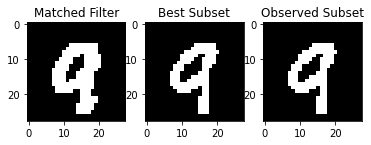

In [98]:
#ALGORITHM:
###########################################################################

delta = 3
F_MAX = 0

for i in range(len(intervals) - 1):

    converged = False

    qmid = (intervals[i] + intervals[i+1])/2

    print("Initial q value: {}".format(qmid))

    while converged == False:

        scores = llr(observed, expected, qmid)
        # print("Scores for data elements: {}".format(scores))

        S = ReLU(scores=scores) #initial subset
        # print("initial subset: {}".format(S))

        # weights = np.ones(len(initial)) #chg
        weights = [delta if np.abs(score) > delta else np.abs(score) for score in scores]
        # print("Weights for initial subset: {}".format(weights))

        Fmax = sum(scores[scores > 0])
        print("Score of subset: {}".format(Fmax))

        filter, distance = tree.traverse(S, weights=weights)
        # print("Best matched filter for subset: {}".format(filter))
        
        pens = np.minimum(np.abs(scores), delta)
        
        F = Fmax - sum(pens[filter != S]) #new score
        print("New score: {}".format(F))

        if F > F_MAX:
            F_MAX = F
            BEST_S = S
            BEST_F = filter
            BEST_W = weights

        S, W = compute_new_subset(scores=scores, filter=filter, delta=delta)
        # print("New subset: {}".format(S))
        # print("Weights for new S: {}".format(W))

        newS = scores
        newEx = expected.copy()
        newObs = observed.copy()
        newS[S == 0] = 0
        newEx[S == 0] = 0
        newObs[S == 0] = 0
        
        qmle =  sum(newObs)/(sum(newEx) + 10e-6) #compute_qmle(newS, expected, 1) #compute qmle of new S
        print("Q_MLE for new subset: {}".format(qmle))
        print("---------------------------------------------------------------------")

        
        
        if np.abs(qmle - qmid) < 0.001:
            converged = True
        else:
            qmid = qmle
    print("#####################################################################")
                
# print("Subset: {} \nBest Matched Filter:\n{} \nScore: {}".format(BEST_S, BEST_F, F_MAX))
plt.subplot(1, 3, 1)
plt.imshow(BEST_F.to_numpy().reshape(28,28), cmap='gray')
plt.title("Matched Filter")

plt.subplot(1, 3, 2)
plt.imshow(BEST_S.reshape(28,28), cmap='gray')
plt.title("Best Subset")

plt.subplot(1, 3, 3)
plt.imshow(observed.to_numpy().reshape(28,28), cmap='gray')
plt.title("Observed Subset")

Initial q value: 1.0000001402458896
Score of subset: 0.0001739048786752359
New score: 0.0001739048716927737
Q_MLE for new subset: 1.6358974275082183
---------------------------------------------------------------------
Score of subset: 432.12220684018195
New score: 364.20279258989837
Q_MLE for new subset: 1.7515151408999083
---------------------------------------------------------------------
Score of subset: 458.11462149920203
New score: 370.79070907225037
Q_MLE for new subset: 1.7515151408999083
---------------------------------------------------------------------
#####################################################################
Initial q value: 1.8232011937143966
Score of subset: 468.7032769328737
New score: 368.4342675208088
Q_MLE for new subset: 1.7515151408999083
---------------------------------------------------------------------
Score of subset: 458.11462149920203
New score: 370.79070907225037
Q_MLE for new subset: 1.7515151408999083
---------------------------------------

Text(0.5, 1.0, 'Observed Subset')

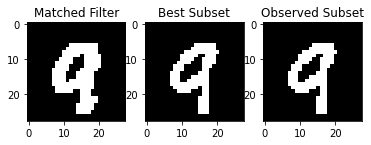

In [99]:
#ALGORITHM:
###########################################################################

delta = 3
F_MAX = 0

for i in range(len(intervals) - 1):

    converged = False

    qmid = (intervals[i] + intervals[i+1])/2

    print("Initial q value: {}".format(qmid))

    while converged == False:

        scores = llr(observed, expected, qmid)
        # print("Scores for data elements: {}".format(scores))

        S = ReLU(scores=scores) #initial subset
        # print("initial subset: {}".format(S))

        # weights = np.ones(len(initial)) #chg
        weights = [delta if np.abs(score) > delta else np.abs(score) for score in scores]
        # print("Weights for initial subset: {}".format(weights))

        Fmax = sum(scores[scores > 0])
        print("Score of subset: {}".format(Fmax))

        filter, distance = no_tree.traverse(S, weights=weights)
        # print("Best matched filter for subset: {}".format(filter))
        
        pens = np.minimum(np.abs(scores), delta)
        
        F = Fmax - sum(pens[filter != S]) #new score
        print("New score: {}".format(F))

        if F > F_MAX:
            F_MAX = F
            BEST_S = S
            BEST_F = filter
            BEST_W = weights

        S, W = compute_new_subset(scores=scores, filter=filter, delta=delta)
        # print("New subset: {}".format(S))
        # print("Weights for new S: {}".format(W))

        newS = scores
        newEx = expected.copy()
        newObs = observed.copy()
        newS[S == 0] = 0
        newEx[S == 0] = 0
        newObs[S == 0] = 0
        
        qmle =  sum(newObs)/(sum(newEx) + 10e-6) #compute_qmle(newS, expected, 1) #compute qmle of new S
        print("Q_MLE for new subset: {}".format(qmle))
        print("---------------------------------------------------------------------")

        
        
        if np.abs(qmle - qmid) < 0.001:
            converged = True
        else:
            qmid = qmle
    print("#####################################################################")
                
# print("Subset: {} \nBest Matched Filter:\n{} \nScore: {}".format(BEST_S, BEST_F, F_MAX))
plt.subplot(1, 3, 1)
plt.imshow(BEST_F.to_numpy().reshape(28,28), cmap='gray')
plt.title("Matched Filter")

plt.subplot(1, 3, 2)
plt.imshow(BEST_S.reshape(28,28), cmap='gray')
plt.title("Best Subset")

plt.subplot(1, 3, 3)
plt.imshow(observed.to_numpy().reshape(28,28), cmap='gray')
plt.title("Observed Subset")

In [281]:
#Notes for the above cell: we create a new subset from scratch every iteration of the while loop based on the latest value of q
#if q or the subset doesnt change, then we break out of the loop and test the next interval